#### Libraries

In [5]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random
from scipy.stats import mode

#### Helper Functions

In [6]:
# Workaround to print images inside the Jupyter Notebook (cv.imshow method seems to be incompatible with Jupyter)
def display_img(image):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [7]:
# Print images side to side for comparison inside the Jupyter Notebook
def display_img_comp(image_1, image_2, lab_1, lab_2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))   

    # Plot data on the first axis
    ax1.imshow(cv.cvtColor(image_1, cv.COLOR_BGR2RGB))
    ax1.set_title(lab_1)
    ax1.axis('off')

    # Plot data on the second axis
    ax2.imshow(cv.cvtColor(image_2, cv.COLOR_BGR2RGB))
    ax2.set_title(lab_2)
    ax2.axis('off')

    fig.tight_layout()
    plt.show()

In [11]:
# The whole pre-processing pipeline for a single image
def preprocess_image(img, resize=True):
    img_p = enhance_contrast_img(img)   
    
    # Resize the image
    if(resize):
        img_p = resize_img(img, 500, 500)
          
    return img_p

In [10]:
# Enhance contrast using Constrast Limited Adaptive Histogram Equalization
def enhance_contrast_img(img, clipLimit=1.0, tileGridSize=(8,8)):
    # Convert the image to 8-bit unsigned single channel (Gray Scale is required for CLAHE)
    img_p = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_p = clahe.apply(img_p)

    return img_p
    
# Resize image
def resize_img(img, width, height):
    img_p = cv.resize(img_p, (width, height))
    return img_p

### Read the Data

In [12]:
# Parameters
width = 2500
height = 2500

# Input & Output Paths
img_paths_src_dict = {
    'training': r'data\Bone Age Datasets\Bone Age Training Set\boneage-training-dataset\boneage-training-dataset'
    , 'validation_1': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-1\boneage-validation-dataset-1'
    , 'validation_2': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-2\boneage-validation-dataset-2'
    , 'test': r'data\Bone Age Datasets\Bone Age Test Set\Test Set Images'
}

img_paths_dest_dict = {
    'training': r'data\pre_processed\training'
    , 'validation_1': r'data\pre_processed\validation\validation_1'
    , 'validation_2': r'data\pre_processed\validation\validation_2'
    , 'test': r'data\pre_processed\test'
}

# Get the relative paths for all images per split of the data
img_rel_paths_dict = {}
images = []

for split in img_paths_src_dict:
    dir = img_paths_src_dict[split]
    file_names = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    relative_paths = [os.path.join(dir, f) for f in file_names]
    img_rel_paths_dict[split] = relative_paths

# Take % amount of samples of images from the training set to analyze
random.seed(642)
perc_samples = 0.25
n_samples = int(round(perc_samples*len(img_rel_paths_dict['training']), 0))
img_paths_analysis = random.sample(img_rel_paths_dict['training'], n_samples)

# Read the images, preprocess and put both the source and the pre-processed image into a dictionary 
for file in img_paths_analysis:
    img_src = cv.imread(file)
    img_p = preprocess_image(img_src, resize=False)
    images.append({'img_src': img_src, 'img_p': img_p})

# Write to file
# path = img_paths_dest_dict['training']

# for i in range(len(images)):
#     img = images[i]['img_p']
#     cv.imwrite('{0}\{1}.png'.format(path, i), img)

### Exploratory Data Analysis

In [13]:
img_list = [img['img_p'] for img in images]

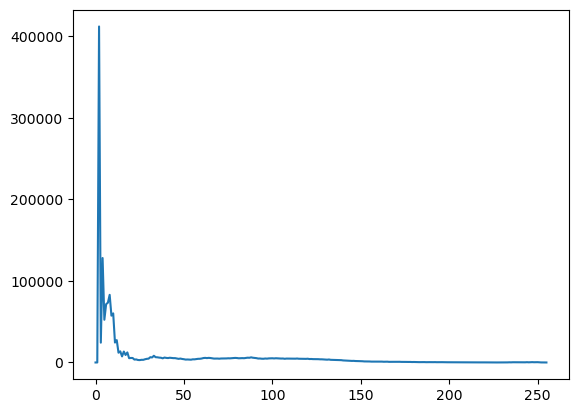

In [14]:
# The histogram for all images
hist = cv.calcHist(img_list, [0], None, [256], [0,256])
plt.plot(hist)
plt.show()

### Analysis Per Image (Tests)

In [23]:
img_comp = images[1]
img = np.copy(img_comp['img_p'])

# First we convert do a binary threshold in the image to make contours more evident
_, img_thr = cv.threshold(img, 170, 255, cv.THRESH_BINARY)

# Gaussian Blur to smooth the image
img_blur = cv.GaussianBlur(img_thr, (33, 33), 3)

# Then we find the contours
contours, hierarchy = cv.findContours(img_blur, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img, contours, -1, (0, 255, 0), 5)
# cv.drawContours(img, contours[hierarchy[0][0][2]], -1, (0,255,0), 5)

array([[[125, 125, 125],
        [129, 129, 129],
        [127, 127, 127],
        ...,
        [118, 118, 118],
        [116, 116, 116],
        [118, 118, 118]],

       [[129, 129, 129],
        [131, 131, 131],
        [125, 125, 125],
        ...,
        [120, 120, 120],
        [116, 116, 116],
        [120, 120, 120]],

       [[129, 129, 129],
        [123, 123, 123],
        [127, 127, 127],
        ...,
        [118, 118, 118],
        [122, 122, 122],
        [116, 116, 116]],

       ...,

       [[129, 129, 129],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [  0, 255,   0],
        [105, 105, 105],
        [105, 105, 105]],

       [[129, 129, 129],
        [127, 127, 127],
        [129, 129, 129],
        ...,
        [107, 107, 107],
        [105, 105, 105],
        [107, 107, 107]],

       [[129, 129, 129],
        [131, 131, 131],
        [133, 133, 133],
        ...,
        [110, 110, 110],
        [110, 110, 110],
        [107, 107, 107]]

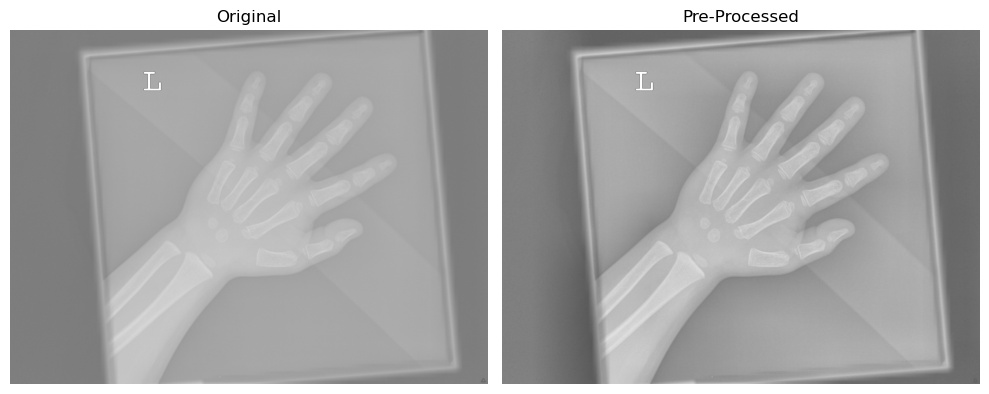

In [24]:
display_img_comp(img_comp['img_src'], img_comp['img_p'], 'Original', 'Pre-Processed')

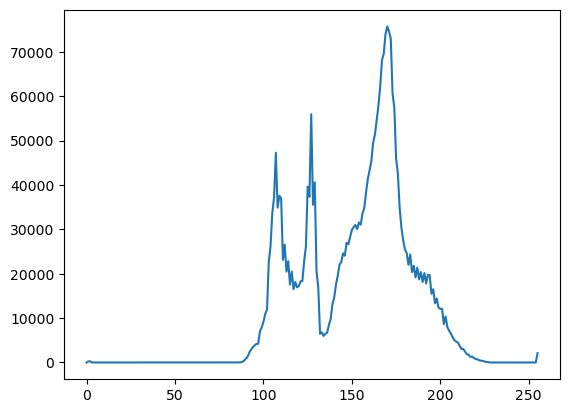

In [25]:
hist = cv.calcHist([img_comp['img_p']],[0],None,[256],[0,256])
plt.plot(hist)
plt.show()

In [26]:
mode_img = mode(img_comp['img_p'].flatten())[0][0]
mode_img

C:\Users\andresespinalh\AppData\Local\Temp\ipykernel_14088\760270510.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_img = mode(img_comp['img_p'].flatten())[0][0]


170

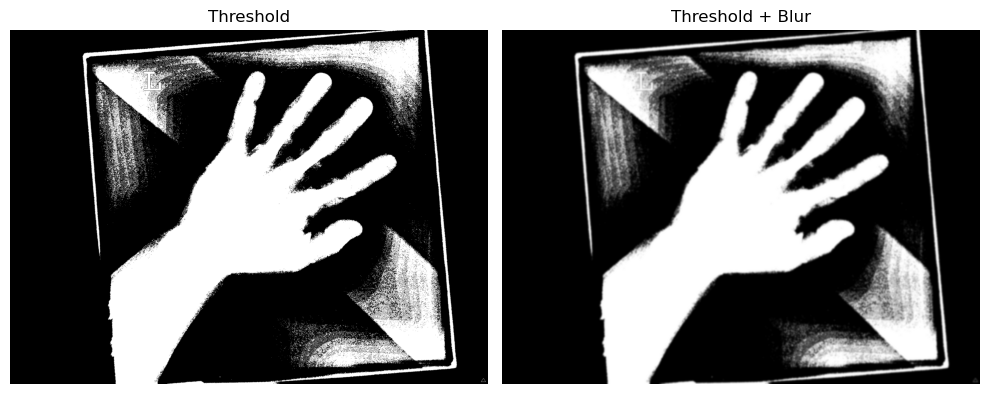

In [27]:
display_img_comp(img_thr, img_blur, 'Threshold', 'Threshold + Blur')

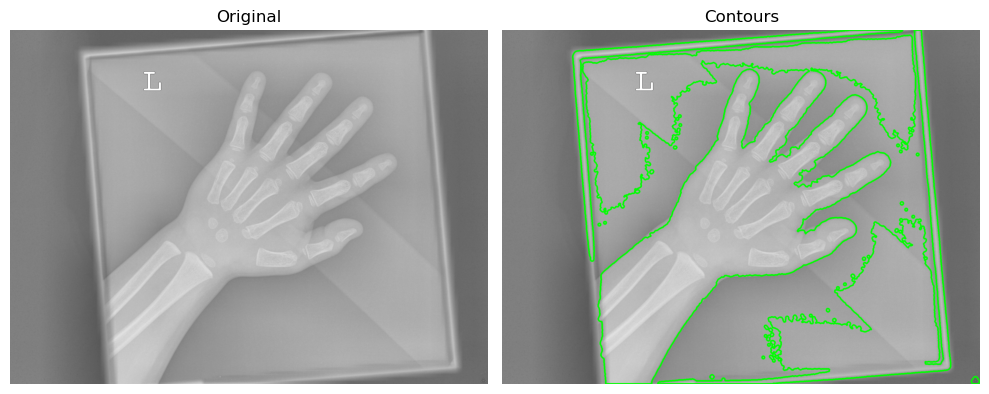

In [28]:
display_img_comp(img_comp['img_p'], img, 'Original', 'Contours')

In [ ]:
# Hola Mundo!

# Como fue el proyecto al final?
# [] Bien
# [] Mal
# [] Que buena pregunta